In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [30]:
import pandas as pd
from pathlib import Path

# Load Excel files
community_df = pd.read_excel("/Users/nikitakumari/Downloads/community_data.xlsx")
firearms_df = pd.read_excel("/Users/nikitakumari/Downloads/Firearms_data.xlsx")
victims_df = pd.read_excel("/Users/nikitakumari/Downloads/victims_data.xlsx")
trend_df = pd.read_excel("/Users/nikitakumari/Downloads/trend_data.xlsx")

# Define preprocessing functions
def clean_community_data(df):
    # Create a copy of the DataFrame to avoid warnings
    df = df.copy()
    df = df.drop_duplicates()
    numeric_cols = df.select_dtypes(include='number').columns
    df.loc[:, numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    categorical_cols = df.select_dtypes(include='object').columns
    df.loc[:, categorical_cols] = df[categorical_cols].fillna('Unknown')
    return df


def clean_firearms_data(df):
    # Create a copy of the DataFrame to avoid warnings
    df = df.copy()
    df.fillna({
        'Used in Shooting?': 0,
        'Modified': 0,
        'Extended Magazine': 0,
        'Legal Purchase': 0,
        'Illegal Purchase': 0,
        'Assembled with Legal Parts': 0,
        'Gifted': 0,
        'Theft': 0,
        'Unknown': 0
    }, inplace=True)
    return df


def clean_trend_data(df):
    df = df.drop_duplicates()
    numeric_cols = df.select_dtypes(include='number').columns
    df.loc[:, numeric_cols] = df[numeric_cols].ffill()
    return df

def clean_victims_data(df):
    df = df.drop_duplicates()
    numeric_cols = df.select_dtypes(include='number').columns
    df.loc[:, numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    categorical_cols = df.select_dtypes(include='object').columns
    df.loc[:, categorical_cols] = df[categorical_cols].fillna('Unknown')
    return df

# Clean dataframes
community_cleaned = clean_community_data(community_df)
firearms_cleaned = clean_firearms_data(firearms_df)
trend_cleaned = clean_trend_data(trend_df)
victims_cleaned = clean_victims_data(victims_df)

# Save cleaned data to CSV files in an existing directory
output_dir = Path("/Users/nikitakumari/Cleaned_Data")
output_dir.mkdir(parents=True, exist_ok=True)

community_cleaned.to_csv(output_dir / "community_cleaned.csv", index=False)
firearms_cleaned.to_csv(output_dir / "firearms_cleaned.csv", index=False)
trend_cleaned.to_csv(output_dir / "trend_cleaned.csv", index=False)
victims_cleaned.to_csv(output_dir / "victims_cleaned.csv", index=False)

print("Cleaned data saved successfully to:", output_dir)


Cleaned data saved successfully to: /Users/nikitakumari/Cleaned_Data


In [44]:
#Hypothesis 5

# Import necessary libraries
from scipy.stats import pearsonr
import statsmodels.api as sm
import pandas as pd

# Ensure 'Case #' exists and no missing values in the relevant columns
combined_data = pd.merge(community_cleaned, firearms_cleaned, on='Case #', how='inner')

# Pearson Correlation: Gun Stores vs. Legal Purchase
correlation, p_value = pearsonr(combined_data['N Gun Stores in Zip Code'].fillna(0), 
                                combined_data['Legal Purchase'].fillna(0))
print(f"Pearson Correlation (Gun Stores vs. Legal Purchase): {correlation}, p-value: {p_value}")

# Multiple Regression: Predict Legal Purchase from Community Resources
X = combined_data[['N Gun Stores in Zip Code', 'N Mental Health Providers in Zip Code']].fillna(0)
y = combined_data['Legal Purchase'].fillna(0)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


Pearson Correlation (Gun Stores vs. Legal Purchase): 0.17626794738838442, p-value: 0.004925294253165697
                            OLS Regression Results                            
Dep. Variable:         Legal Purchase   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     4.444
Date:                Sat, 07 Dec 2024   Prob (F-statistic):             0.0127
Time:                        14:47:39   Log-Likelihood:                -364.51
No. Observations:                 253   AIC:                             735.0
Df Residuals:                     250   BIC:                             745.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]


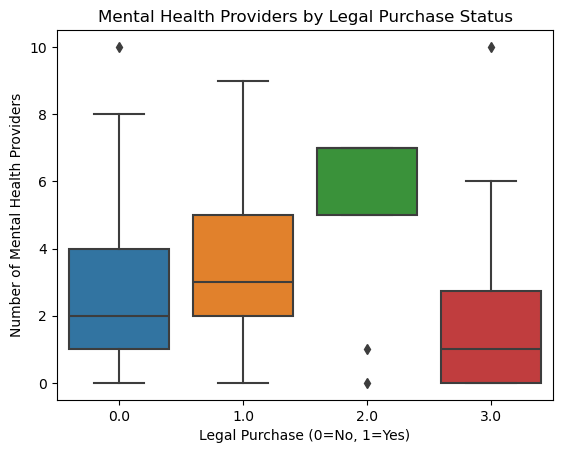

In [41]:
#hypo 5# Boxplot for Mental Health Providers by Legal Purchase Status
sns.boxplot(x='Legal Purchase', y='N Mental Health Providers in Zip Code', data=combined_data)
plt.title("Mental Health Providers by Legal Purchase Status")
plt.xlabel("Legal Purchase (0=No, 1=Yes)")
plt.ylabel("Number of Mental Health Providers")
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


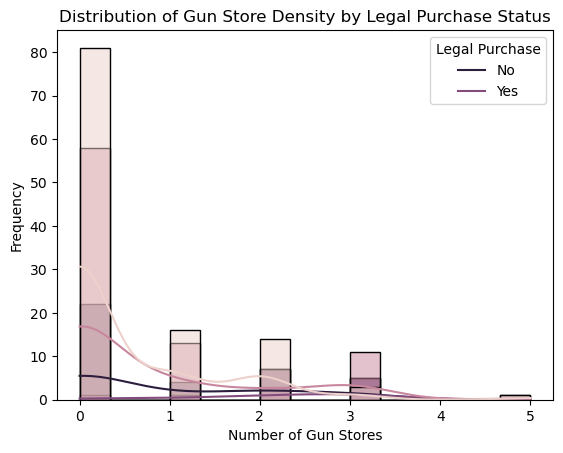

In [43]:
#hypo5 # Histogram of Gun Stores for Legal Purchases
sns.histplot(data=combined_data, x='N Gun Stores in Zip Code', hue='Legal Purchase', kde=True, bins=15)
plt.title("Distribution of Gun Store Density by Legal Purchase Status")
plt.xlabel("Number of Gun Stores")
plt.ylabel("Frequency")
plt.legend(title="Legal Purchase", labels=["No", "Yes"])
plt.show()


ANOVA Test: F-statistic=8.238868564153403, p-value=1.1385964644250906e-07


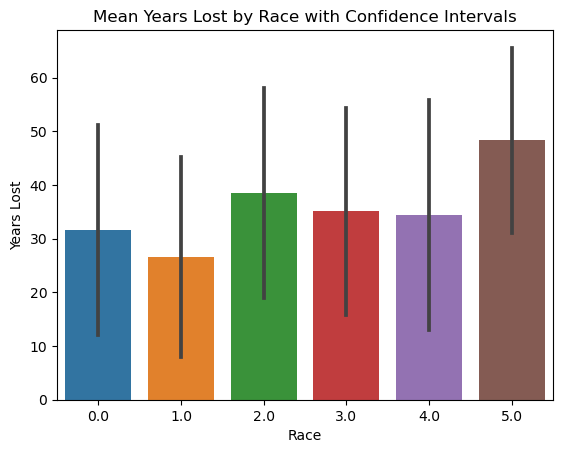

In [37]:
#hypothesis6

# Load cleaned data
victims_cleaned = pd.read_csv("/Users/nikitakumari/Cleaned_Data/victims_cleaned.csv")

# Clean the 'Years Lost' column to ensure numeric conversion
victims_cleaned['Years Lost'] = (
    victims_cleaned['Years Lost']
    .astype(str)               # Convert all values to string for uniformity
    .str.replace(',', '')      # Remove commas
    .replace('Unknown', '0')   # Replace 'Unknown' with '0'
    .astype(float)             # Convert to float
)

# ANOVA Test: Group Years Lost by Race
groups = [group['Years Lost'].values for _, group in victims_cleaned.groupby('Race')]
anova_stat, anova_p = f_oneway(*groups)
print(f"ANOVA Test: F-statistic={anova_stat}, p-value={anova_p}")

# Visualization: Mean Years Lost by Race with Standard Deviation
sns.barplot(x='Race', y='Years Lost', data=victims_cleaned, errorbar='sd')
plt.title("Mean Years Lost by Race with Confidence Intervals")
plt.xlabel("Race")
plt.ylabel("Years Lost")
plt.show()

                            OLS Regression Results                            
Dep. Variable:        Q("Years Lost")   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     1160.
Date:                Sat, 07 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:41:08   Log-Likelihood:                -4229.8
No. Observations:                1267   AIC:                             8478.
Df Residuals:                    1258   BIC:                             8524.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         67.6752      0.664    101.

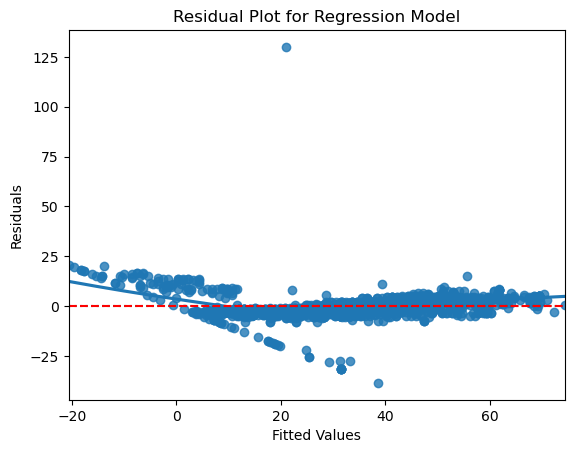

In [38]:
#hypothesis6:Linear Regression with Interaction Terms
import statsmodels.formula.api as smf

# Create a regression model with interaction terms
model = smf.ols('Q("Years Lost") ~ Age + Gender + C(Race) + Age:Gender', data=victims_cleaned).fit()
print(model.summary())

# Visualization: Residual plot for model fit
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True)
plt.axhline(0, linestyle='--', color='red')
plt.title("Residual Plot for Regression Model")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()


Chi-Square Test: Chi2=31.592210092295236, p-value=7.15454298155096e-06


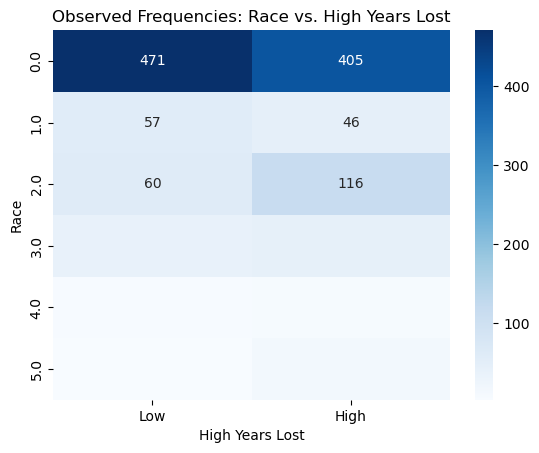

In [39]:
#hypothesis6: 3. Chi-Square Test for Independence
from scipy.stats import chi2_contingency

# Create a binned column for high vs. low years lost
victims_cleaned['High Years Lost'] = pd.qcut(victims_cleaned['Years Lost'], q=2, labels=['Low', 'High'])

# Contingency table for Race and High Years Lost
contingency_table = pd.crosstab(victims_cleaned['Race'], victims_cleaned['High Years Lost'])

# Chi-Square Test
chi2_stat, chi2_p, _, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Test: Chi2={chi2_stat}, p-value={chi2_p}")

# Visualization: Heatmap of observed vs. expected frequencies
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
plt.title("Observed Frequencies: Race vs. High Years Lost")
plt.xlabel("High Years Lost")
plt.ylabel("Race")
plt.show()
